In [1]:
import numpy as np
import csv
steer_angle = []
samples = []
with open('./data/driving_log.csv') as csvfile:
    next(csvfile) # get rid of the header
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
# print(len(samples))

for i in range (0, len(samples)):
    sample = samples[i];
    steer_angle.append(float(sample[3]))

steer_angle = np.asarray(steer_angle)
steer_angle.shape

8036


(8036,)

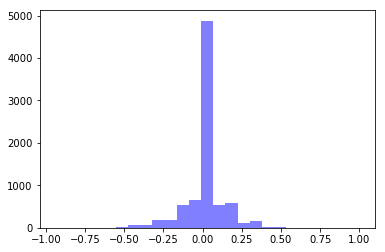

[-0.9426954  -0.86498758 -0.78727977 -0.70957195 -0.63186414 -0.55415632
 -0.4764485  -0.39874069 -0.32103287 -0.24332506 -0.16561724 -0.08790942
 -0.01020161  0.06750621  0.14521402  0.22292184  0.30062966  0.37833747
  0.45604529  0.5337531   0.61146092  0.68916874  0.76687655  0.84458437
  0.92229218  1.        ]
[  4.00000000e+00   1.00000000e+00   2.00000000e+00   2.00000000e+00
   4.00000000e+00   1.80000000e+01   5.50000000e+01   5.50000000e+01
   1.74000000e+02   1.93000000e+02   5.32000000e+02   6.56000000e+02
   4.88000000e+03   5.27000000e+02   5.77000000e+02   1.22000000e+02
   1.69000000e+02   2.60000000e+01   2.50000000e+01   6.00000000e+00
   5.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   2.00000000e+00]


In [3]:
# I decided to look into the imbalance distribution of data around zero (driving straight).
# The first step is to show the histogram

import matplotlib.pyplot as plt
num_bins = 25

n, bins, patches = plt.hist(steer_angle, num_bins, facecolor='blue', alpha=0.5)
plt.show()
#print(bins)
#print(n)

array = np.arange(num_bins)
bins_range = -1.0 + 2.0/num_bins * (array)
hist = np.histogram(steer_angle, bins_range)
plt.close('all')

lenth of data samples = 8036


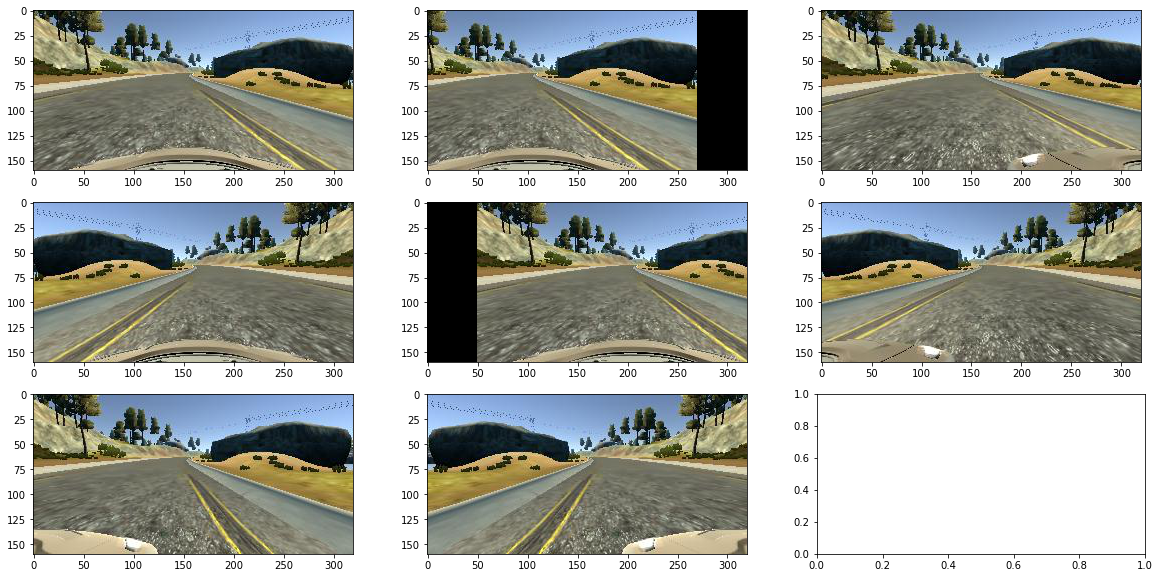

-0.6863848 -0.9363848 -0.4363848
0.6863848 -0.4363848 0.4363848
-0.9363848 0.9363848


In [38]:
### After seeing the inbalance of training data, 
### The following code will try to use left and right side cameras and data augmentation
samples = []
with open('./data/driving_log.csv') as csvfile:
    next(csvfile) # get rid of the header
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
#print('lenth of data samples =', len(samples))

# Show one example
index = 1182
show_images = []
show_measurements = []

show_sample = samples[index]
angle_adjust = 0.25

for i in range(3):
    file_name = show_sample[i].split('/')[-1]
    file_directory = './data/IMG/' + file_name
    new_image = cv2.imread(file_directory)
    ### imread returns BGR, im.show uses RGB
    new_image = new_image[...,[2,1,0]]
    show_images.append(new_image)

    # use similar procedure for steering, but steering need offset for left and right cameras
    # Note that left and right have opposite offset
    new_measurment = float(show_sample[3]) + angle_adjust * ((i+1)%3-1)
    show_measurements.append(new_measurment)
    
    ## Data Augmentation 
    ## The First step is flip horizontally
    flipped_img = cv2.flip(new_image, 1 )
    show_images.append(flipped_img)
    show_measurements.append(-1.0 * new_measurment)
    
    ## Secondly for the CENTER camera ONLY: shift the images horizontally, and then shift the steer accordingly
    ## The shifted distance is roughly equivalent to the offset between side camera and center camera so that the same 
    ## parameter angle_adjust = 0.25 is used for both side cameras and shifted img
    if i == 0:
        rows,cols = new_image.shape[:-1]
        
        shift_Left = np.float32([[1,0,-50],[0,1,0]])
        shift_LeftImage = cv2.warpAffine(new_image, shift_Left,(cols,rows))
        show_images.append(shift_LeftImage)
        show_measurements.append(float(show_sample[3]) - angle_adjust)
        
        shift_Right = np.float32([[1,0,50],[0,1,0]])
        shift_RightImage = cv2.warpAffine(new_image, shift_Right,(cols,rows))
        show_images.append(shift_RightImage)
        show_measurements.append(float(show_sample[3]) + angle_adjust)
    
f, axarr = plt.subplots(3,3, figsize=(20, 10))

axarr[0,0].imshow(show_images[0])
axarr[1,0].imshow(show_images[0+1])
axarr[0,1].imshow(show_images[0+2])
axarr[1,1].imshow(show_images[0+3])
axarr[0,2].imshow(show_images[0+4])
axarr[1,2].imshow(show_images[0+5])
axarr[2,0].imshow(show_images[0+6])
axarr[2,1].imshow(show_images[0+7])
plt.show()

print(show_measurements[0], show_measurements[0+2], show_measurements[0+4] )
print(show_measurements[0+1], show_measurements[0+3], show_measurements[0+5] )
print(show_measurements[0+6], show_measurements[0+7])

lenth of data samples = 8036
(4773,)
4773


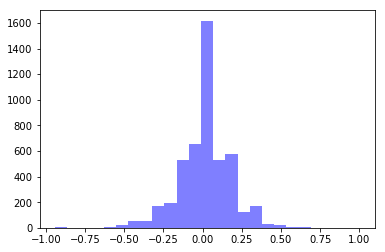

(array([   4,    0,    2,    3,    4,    3,   35,   63,  131,  219,  385,
        729, 1466,  661,  673,  139,  159,   49,   34,    6,    5,    1,
          0,    0]), array([-1.  , -0.92, -0.84, -0.76, -0.68, -0.6 , -0.52, -0.44, -0.36,
       -0.28, -0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,  0.36,
        0.44,  0.52,  0.6 ,  0.68,  0.76,  0.84,  0.92]))


In [31]:
### In order to address the inbalanced data, only a quarter (25%) of the data with steering = 0.0 are used

### reload the data

import matplotlib.pyplot as plt
import csv
import numpy as np
num_bins = 25

array = np.arange(num_bins)
bins_range = -1.0 + 2.0/num_bins * (array)


samples = []
with open('./data/driving_log.csv') as csvfile:
    next(csvfile) # get rid of the header
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
print('lenth of data samples =', len(samples))

# All other points are OK. Just deal with angle = 0.0
steer_angle_balanced = []
subset_samples = []

for i in range(0, len(samples)):
    sample = samples[i]
    if float(sample[3]) != 0.0 or (i%4 == 0):
        steer_angle_balanced.append(float(sample[3]))
        subset_samples.append(sample)

steer_angle_balanced = np.asarray(steer_angle_balanced)   
print(steer_angle_balanced.shape)
print(len(subset_samples))

n_int, bins, patches = plt.hist(steer_angle_balanced, num_bins, facecolor='blue', alpha=0.5)

# raw data summary
plt.show()
plt.close()
hist = np.histogram(steer_angle_balanced, bins_range)
print(hist)


In [41]:
### this is to use subset to see if the model can improve with less imbalanced training data ...
samples = subset_samples
#print("Sample size = " , len(samples))
###

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size = 0.2)

import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle
batch_size_const = 64

def generator_balance(samples, batch_size = batch_size_const):
    num_samples = len(samples)
    angle_adjust = 0.25 # this a0.25  0.2

    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for batch_sample in batch_samples:                
                ## Turn on left and right camera
                for i in range(3):
                    file_name = batch_sample[i].split('/')[-1]
                    file_directory = './data/IMG/' + file_name
                    new_image = cv2.imread(file_directory)
                    # BGR to RGB is VERY IMPORTANT
                    new_image = new_image[...,[2,1,0]]
                    images.append(new_image)

                    # use similar procedure for steering, but steering need offset for left and right cameras
                    # Note that left and right have opposite offset
                    new_measurment = float(batch_sample[3]) + angle_adjust * ((i+1)%3-1)
                    measurements.append(new_measurment)
    
                    ## Data Augmentation 
                    ## The First step is flip horizontally
                    flipped_img = cv2.flip(new_image, 1 )
                    images.append(flipped_img)
                    measurements.append(-1.0 * new_measurment)
                    
                    ## Secondly for the CENTER camera ONLY, 
                    ## try to shift the images horizontally and shift the steer accordingly
                    ## In the testing of models, it shows that without the shifting, 
                    ## the model has already achieved the goal of finishing one lap. Currently disabled
                    if False: ### if i == 0 and new_measurment == 0.0:
                        rows,cols = new_image.shape[:-1]
        
                        shift_Left = np.float32([[1,0,-50],[0,1,0]])
                        shift_LeftImage = cv2.warpAffine(new_image, shift_Left,(cols,rows))
                        show_images.append(shift_LeftImage)
                        show_measurements.append(float(show_sample[3]) - angle_adjust)

                        shift_Right = np.float32([[1,0,50],[0,1,0]])
                        shift_RightImage = cv2.warpAffine(new_image, shift_Right,(cols,rows))
                        show_images.append(shift_RightImage)
                        show_measurements.append(float(show_sample[3]) + angle_adjust)
                    
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator_balance(train_samples, batch_size = batch_size_const)
validation_generator = generator_balance(validation_samples, batch_size = batch_size_const)

#print("Validation size = ", len(validation_samples))

Sample size =  4773
Validation size =  955


Epoch 1/5
22908/22908 [==============================] - 254s - loss: 0.0345 - val_loss: 0.0263
Epoch 2/5
22908/22908 [==============================] - 254s - loss: 0.0258 - val_loss: 0.0197
Epoch 3/5
22908/22908 [==============================] - 253s - loss: 0.0241 - val_loss: 0.0238
Epoch 4/5
22908/22908 [==============================] - 253s - loss: 0.0219 - val_loss: 0.0209
Epoch 5/5
22908/22908 [==============================] - 253s - loss: 0.0205 - val_loss: 0.0168
dict_keys(['loss', 'val_loss'])


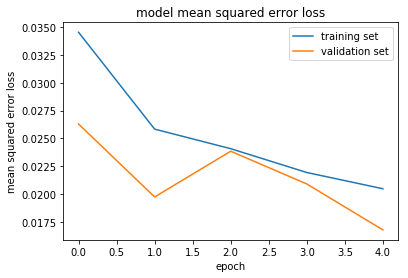

In [44]:
crop_top = 50
crop_bottom = 25
crop_total = crop_bottom + crop_top

from keras.models import Sequential
from keras.layers import Input, Lambda, Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from keras.backend import tf as ktf
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils


model = Sequential()
#preprocessing
model.add(Lambda(lambda X_train: (X_train - 128)/255.0, input_shape = (160, 320, 3)))
model.add(Cropping2D(cropping = ((crop_top, crop_bottom),(0,0))))

#CNN layers
model.add(Convolution2D(24, 5, 5, subsample = (2, 2), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))
model.add(Convolution2D(36, 5, 5, subsample = (2, 2), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))
model.add(Convolution2D(48, 5, 5, subsample = (2, 2), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.2))
model.add(Convolution2D(64, 3, 3, activation='relu'))

model.add(Convolution2D(64, 3, 3, activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
#model.add(Dropout(0.5))
model.add(Dense(1))


model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples)*6, validation_data=validation_generator,
            nb_val_samples= len(validation_samples), nb_epoch = 5, verbose = 1)  
model.save('model_3cameras_balance_RGB.h5')

print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
